In [1]:
# Thsi is the code used for the paper results
# How changing the dataset sample size effects the calibration methods
# Fix training dataset size and change the calib set samples - best method is one that gets max calib with least data

# imports
import os
import sys
import numpy as np 
import pandas as pd
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import core_exp as cx
import core_calib as cal
import core_tools as ct
import matplotlib.pyplot as plt


In [2]:
params = {
    # exp
    "seed": 0,
    "runs": 10,
    "exp_name": ct.generate_readable_short_id("Paper_v1_feature_size"),
    "path": "../../",
    "split": "CV", #CV, random_split
    "cv_folds": 10,

    # "test_split": 0.1,
    # "calib_split": 0.11,
    
    "plot": False,
    "calib_methods": ["RF_d", "RF_opt", "RF_large",
                      "Platt", "ISO", "Beta", "CRF", "VA",
                      "tlr", "Rank", "Elkan",                      
                      ],
    
    "metrics": ["acc", "brier", "ece", "logloss", "tce"],

    #data
    "data_name": "synthetic",
    "plot_data": True,
    "data_size": 1000,
    "n_features": 2,

    "class1_mean_min":0, 
    "class1_mean_max":1,
    "class2_mean_min":0, 
    "class2_mean_max":1, 


    # calib param
    "bin_strategy": "uniform",
    "ece_bins": 20,
    "boot_size": 1000, 
    "boot_count": 5,

    # RF hyper opt
    "hyper_opt": True,
    "opt_cv":5, 
    "opt_n_iter":50,
    "opt_top_K": 5,
    "search_space": {
                    "n_estimators": [10],
                    "max_depth": np.arange(2, 100).tolist(),
                    "criterion": ["gini", "entropy"],
                    "max_features": ['sqrt', 'log2', None],
                    "min_samples_split": np.arange(2, 11).tolist(),
                    "min_samples_leaf": np.arange(1, 11).tolist(),
                    # 'bootstrap': [True, False],                # Whether bootstrap samples are used
                    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Weight for each class
                    "oob_score": [False]
                    },
    
    "oob": False,
    "laplace": 0, # if set to 1, OOB must be false

    "exp_key": "n_features",
    "exp_values":  np.arange(2, 50, 1).tolist()
}

ct.save_params(params)

In [3]:
calib_results_dict, data_list = cx.run_exp(params["exp_key"], params["exp_values"], params)
ct.save_results(calib_results_dict, params['exp_name'])

Success in 2 n_features
exp_param 2 done
Success in 7 n_features
exp_param 7 done
Success in 12 n_features
exp_param 12 done
Success in 17 n_features
exp_param 17 done
Success in 22 n_features
exp_param 22 done
Success in 27 n_features
exp_param 27 done
Success in 32 n_features
exp_param 32 done
Success in 37 n_features
exp_param 37 done
Success in 42 n_features
exp_param 42 done
Success in 47 n_features
exp_param 47 done


In [4]:
plot_calib_methods = params["calib_methods"].copy()
plot_calib_methods.remove("RF_large")
# plot_calib_methods.remove("Elkan")
# plot_calib_methods.remove("RF")
plot_calib_methods

['RF_d', 'RF_opt', 'Platt', 'ISO', 'Beta', 'CRF', 'VA', 'tlr', 'Rank']

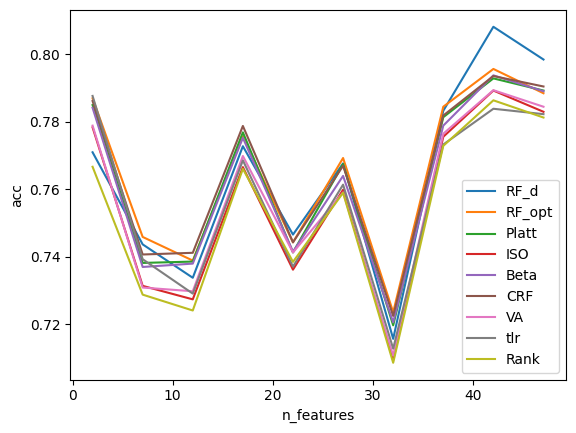

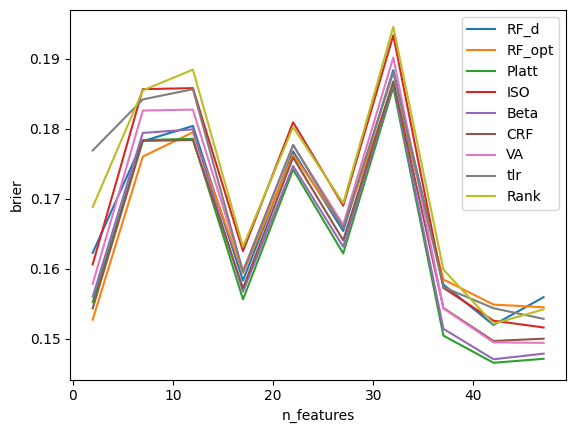

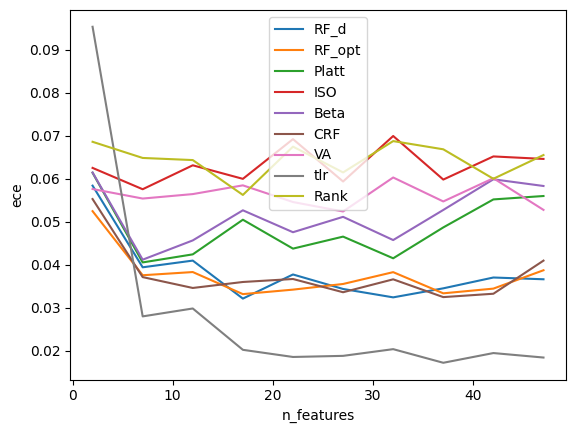

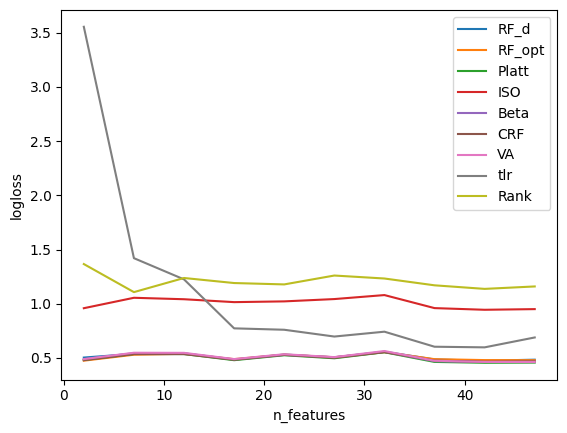

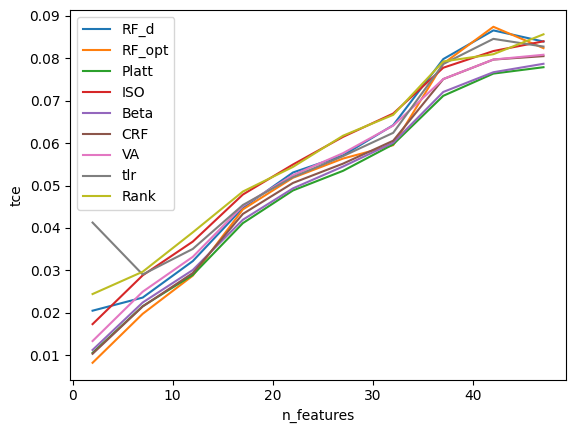

In [5]:
tables = cal.mean_and_ranking_table(calib_results_dict, 
                                    params["metrics"], 
                                    params["calib_methods"], 
                                    data_list, 
                                    mean_and_rank=False, 
                                    std=True)

path = f"results/{params['exp_name']}/features"
if not os.path.exists(path):
    os.makedirs(path)

for metric in params["metrics"]: #
    ax = tables[metric][plot_calib_methods].plot()
    ax.set_xlabel(params["exp_key"])
    ax.set_ylabel(metric)
    plt.savefig(f"{path}/f_{metric}.pdf", format='pdf', transparent=True)
    plt.close() 
